### Reference

[Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

In [115]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F

In [116]:
class Lenet5(nn.Module):
    def __init__(self, input_channels: int = 1, num_classes: int = 10):
        super().__init__()
        
        self.c1 = nn.Conv2d(in_channels=input_channels, out_channels=6, kernel_size=5)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        # self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc6 = nn.Linear(120, 84)
        self.out = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.c1(x)
        x = torch.tanh(x)
        x = F.avg_pool2d(x, 2, 2)
        x = self.c3(x)
        x = torch.tanh(x)
        x = F.avg_pool2d(x, 2, 2)
        x = self.c5(x)
        x = torch.tanh(x) # x.shape[240, 1]
        x = x.view(-1, 120) # x.shape[-1, 120]
        x = self.fc6(x) # self.fc6 shape[120, 84]
        x = torch.tanh(x)
        x = self.out(x)

        return F.softmax(x, dim=1)

In [117]:
model = Lenet5(input_channels=3)
print(model)


Lenet5(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


In [118]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [119]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


# CUDA Check

사용 가능한 GPU를 확인합니다.

# MNIST Dataset 불러오기

Lenet5를 학습하기 위해 MNIST 데이터 세트를 불러옵니다. torchvision 패키지에서 지원하는 MNIST dataset을 사용합니다.

In [120]:
from torchvision import datasets, transforms

#define data transform function
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

data_path = './data'

# define dataset
train_dataset = datasets.MNIST(data_path, train=True, download=True, transform=data_transforms)
val_dataset = datasets.MNIST(data_path, train=False, download=True, transform=data_transforms)

# CIFAR10 Dataset 불러오기

In [121]:
train_dataset = datasets.CIFAR10(data_path, train=True, download=True, transform=data_transforms)
val_dataset = datasets.CIFAR10(data_path, train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Show Sample Images

In [122]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

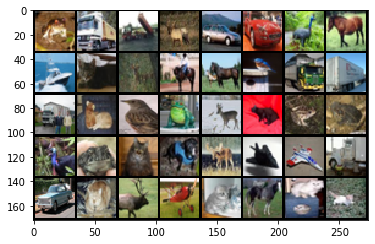

In [123]:
x_train, y_train = train_dataset.data, train_dataset.targets
x_val, y_val = val_dataset.data, val_dataset.targets

# x_train shape: [batch, height, width]
# 차원을 추가해서 B*C*H*W가 되도록 한다.
if len(x_train.shape) == 3:
    # x_train shape: [batch, 1, height, width]
    x_train = x_train.unsqueeze(1)

if len(x_val) == 3:
    x_val = x_val.unsqueeze(1)

# convert Tensor to image
def show(img):
    # convert Tensor to numpy array
    np_img = img.numpy()
    # [C, H, W] -> [H, W, C]
    np_img = np_img.transpose((1, 2, 0))

    plt.imshow(np_img, interpolation='nearest')
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)) if isinstance(x_train, np.ndarray) else x_train
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2)
show(x_grid)

# Data Loader 생성

In [124]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss Function, Optimizer 생성하기

In [125]:
# loss
loss_func = nn.CrossEntropyLoss(reduction='sum')

from torch import optim
# optimizer
opt = optim.Adam(model.parameters(), lr=0.001)

# 현재 lr을 계산하는 함수
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# lr scheduler 정의
from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)

In [126]:
# 배치당 performance metric을 계산하는 함수
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    # pred와 target이 같은 element를 찾아서 모두 더한다.
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [127]:
# 배치당 loss를 계산하는 함수
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metrics = metrics_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metrics

In [128]:
# epoch당 loss와 performance metric을 계산하는 함수
def loss_epoch(model, loss_func, data_loader, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    total_data = len(data_loader.dataset)

    for x_data, y_data in data_loader:
        x_data = x_data.type(torch.float).to(device)
        y_data = y_data.to(device)
        output = model(x_data)
        losses, metric_batch = loss_batch(loss_func, output, y_data, opt)
        running_loss += losses

        if metric_batch is not None:
            running_metric += metric_batch

        if sanity_check:
            break

    loss = running_loss / float(total_data)
    metric = running_metric / float(total_data)

    return loss, metric


In [129]:
import copy

def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dataloader = params['train_dataloader']
    val_dataloader = params['val_dataloader']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': []
    }

    metric_history = {
        'train': [],
        'val': []
    }

    # best model parameter 저장
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print(f"Epoch {epoch}/{num_epochs-1} current lr={current_lr}")
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dataloader, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dataloader, sanity_check)
            loss_history['val'].append(val_loss)
            metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')

        lr_scheduler.step()
        print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {(100*val_metric):.2f}")
        print('-'*10)
    model.load_state_dict(best_model_weights)
    return model, loss_history, metric_history

# Train Model

In [137]:
import os

os.makedirs('models', exist_ok=True)

params_train = {
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "models/LeNet-5.pt",
}

In [138]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/49 current lr=0.0005050000000000006
Copied best model weights
train loss: 1.919565, val loss: 1.959213, accuracy: 49.96
----------
Epoch 1/49 current lr=1e-05
Copied best model weights
train loss: 1.897141, val loss: 1.953715, accuracy: 50.47
----------
Epoch 2/49 current lr=0.0005049999999999999
train loss: 1.909756, val loss: 1.954255, accuracy: 50.15
----------
Epoch 3/49 current lr=0.0010000000000000024
train loss: 1.929799, val loss: 1.963075, accuracy: 49.36
----------
Epoch 4/49 current lr=0.0005050000000000008
Copied best model weights
train loss: 1.897875, val loss: 1.952796, accuracy: 50.51
----------
Epoch 5/49 current lr=1e-05
Copied best model weights
train loss: 1.869988, val loss: 1.941937, accuracy: 51.47
----------
Epoch 6/49 current lr=0.0005049999999999999
train loss: 1.882247, val loss: 1.945765, accuracy: 51.33
----------
Epoch 7/49 current lr=0.0010000000000000026
train loss: 1.904093, val loss: 1.951871, accuracy: 50.65
----------
Epoch 8/49 current lr=0.

In [132]:
print(metric_hist)

{'train': [0.30988, 0.39594, 0.42354], 'val': [0.3702, 0.4117, 0.4202]}


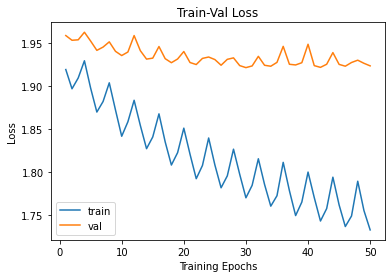

In [139]:
num_epochs=params_train['num_epochs']

plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label="train")
plt.plot(range(1, num_epochs+1), loss_hist['val'], label="val")
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

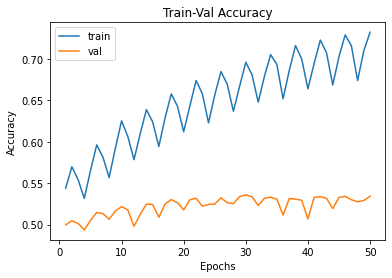

In [140]:
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()